In [53]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from pyearth import Earth
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [54]:
data = pd.read_csv('us_used_cars_final.csv')
data.head(2)

,vin,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,...,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width,year
0,5LMCJ2C97HUL71203,36.8 in,SUV / Crossover,Devine,21.0,40,78016,*We have 19 sources of financing and second ch...,I4,2000.0,...,"270 lb-ft @ 3,000 RPM",A,Automatic,t66989,Select FWD,FWD,Front-Wheel Drive,105.9 in,84.1 in,2017
1,1FM5K8D87HGE07214,39.5 in,SUV / Crossover,Buffalo,16.0,9,55313,We are open for business. Purchase your nex...,V6,3500.0,...,"255 lb-ft @ 4,000 RPM",A,6-Speed Automatic,t67141,XLT AWD,AWD,All-Wheel Drive,112.8 in,90.2 in,2017


## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Hiba Khatib*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


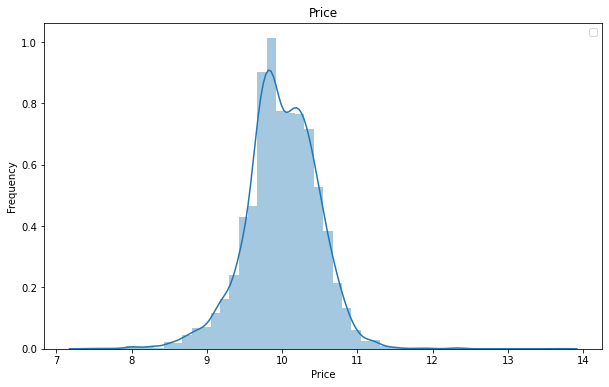

Mean of price:  24568.3835
Standard deviation:  16742.99685916766


In [55]:
#...Plot for distribution of response...#

plt.figure(figsize=(10,6))
sns.distplot(np.log(data.price))
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
#removing the scientific notation
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data.price))
print("Standard deviation: ", np.std(data.price))

<AxesSubplot:xlabel='price'>

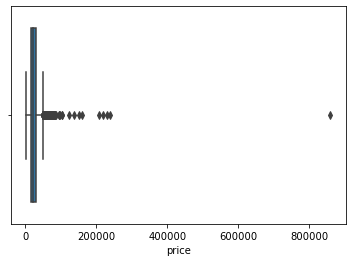

In [107]:
# checking for outlying observations 
sns.boxplot(data_2.price, orient = "v")

### Data Cleaning, Preparation, and EDA
*By Hiba Khatib & Emily Leibfritz*

### brief summary of all the things we did 

In [56]:
# feature engineering

    # encoding True/False as 1/0s
bool_cols = data.dtypes[data.dtypes == bool]
bool_cols = pd.DataFrame(bool_cols).reset_index()
bool_cols = bool_cols['index']
bool_cols = list(bool_cols)
print(bool_cols)
for col in bool_cols:
    data[col] = data[col].map({False: 0, True: 1})
    

    # numerically encoding categorical variables with at most 5 unique values 
cols_map = []
for c in data.columns:
    col_len = (len(data[c].unique()))
    if col_len <=5:
        cols_map.append(c)
[cols_map.remove(c) for c in bool_cols] # removing the boolean columns from the list

    # performing the encoding
le = LabelEncoder()
encoder_dict = {key: None for key in cols_map}
for c in cols_map:
    encoder_dict[c] = data[c].unique()
    col_name = str(c)+"_cat"
    data[col_name] = le.fit_transform(data[c])
    encoder_dict[col_name] = le.fit_transform(encoder_dict[c])
    
    # removing units from numerical columns 

data['front_legroom'] = data['front_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['width'] = data['width'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['height'] = data['height'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['length'] = data['length'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['wheelbase'] = data['wheelbase'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['back_legroom'] = data['back_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['maximum_seating'] = data['maximum_seating'].map(lambda x: x.lstrip('+-').rstrip('seating'))
data['fuel_tank_volume'] = data['fuel_tank_volume'].map(lambda x: x.lstrip('+-').rstrip('gal'))
data['power'] = data['power'].str[:3] # keeping only numerical value
data['torque'] = data['torque'].str[:3]

    # converting data types to numerical
data.power = pd.to_numeric(data.power)
data.back_legroom = pd.to_numeric(data.back_legroom)
data.front_legroom = pd.to_numeric(data.front_legroom)
data.width = pd.to_numeric(data.width)
data.height = pd.to_numeric(data.height)
data.length = pd.to_numeric(data.length)
data.wheelbase = pd.to_numeric(data.wheelbase)
data.maximum_seating = pd.to_numeric(data.maximum_seating)
data.fuel_tank_volume = pd.to_numeric(data.fuel_tank_volume)
data.torque = pd.to_numeric(data.torque)

['fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents', 'isCab', 'is_new', 'salvage', 'theft_title']


In [57]:
data.columns

Index(['vin', 'back_legroom', 'body_type', 'city', 'city_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_new', 'latitude', 'length', 'listed_date', 'listing_color',
       'listing_id', 'longitude', 'main_picture_url', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'power', 'price', 'salvage', 'savings_amount', 'seller_rating', 'sp_id',
       'sp_name', 'theft_title', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name', 'wheel_system',
       'wheel_system_display', 'wheelbase', 'width', 'year', 'fuel_type_cat',
       'transmission_cat', 'wheel_system_cat', 'wheel_syst

In [58]:
# dropping unique features

data.drop(columns = ['vin', 'listing_id', 'main_picture_url', 'description', 'sp_name', 'make_name', 'city'], inplace = True)

    # color columns
data.drop(columns = ['listing_color', 'interior_color', 'exterior_color'], inplace = True)

print("Data shape after dropping unique features: ", data.shape)

# dropping constant predictor 
print(data.nunique() == 1)
data.drop(columns = ['franchise_dealer'], inplace = True)

# dropping highly correlated columns 

data.drop(columns = ['trim_name', 'engine_type', 'major_options', 'horsepower'], inplace = True)

Data shape after dropping unique features:  (6000, 51)
back_legroom                False
body_type                   False
city_fuel_economy           False
daysonmarket                False
dealer_zip                  False
engine_cylinders            False
engine_displacement         False
engine_type                 False
fleet                       False
frame_damaged               False
franchise_dealer             True
franchise_make              False
front_legroom               False
fuel_tank_volume            False
fuel_type                   False
has_accidents               False
height                      False
highway_fuel_economy        False
horsepower                  False
isCab                       False
is_new                      False
latitude                    False
length                      False
listed_date                 False
longitude                   False
major_options               False
maximum_seating             False
mileage                    

In [59]:
print("Final data shape after cleaning and dropping unnecessary features: ", data.shape)

Final data shape after cleaning and dropping unnecessary features:  (6000, 46)


### Exploring Trends in Categorical Predictors

In [60]:
data_2 = data.copy()
# make seperate df to just look at categorical
o_data = data.drop(columns = ["back_legroom", "wheel_system_display", "wheelbase", "width", "front_legroom", 
                              "fuel_tank_volume", "height", "torque", "maximum_seating","transmission_cat",
                              "power","city_fuel_economy","daysonmarket","dealer_zip","transmission","wheel_system_display_cat",
                              "fuel_type_cat","wheel_system","wheel_system_cat","fuel_type",
                              "engine_displacement","fleet","frame_damaged","has_accidents","highway_fuel_economy",
                              "isCab","is_new","latitude","longitude","mileage","owner_count","salvage",
                              "savings_amount","seller_rating","sp_id","theft_title","year"], axis = 1)
# taken out: "franchise_dealer"
cols = o_data.columns
name = []
unique_value = []
for i in range(0,len(cols)):
    c = cols[i]
    unique = len(data[c].unique())
    unique_value.append(unique)
    name.append(c)

In [61]:
# Create the pandas DataFrame with object columns and their unique values
data_ = {'column': name, 'unique_values':unique_value}
o_unique_values_count = pd.DataFrame(data_)
o_unique_values_count.sort_values(by=['unique_values'])

,column,unique_values
0,body_type,9
1,engine_cylinders,20
7,transmission_display,21
2,franchise_make,40
4,listed_date,321
5,model_name,361
3,length,384
8,trimId,3087
6,price,3531


From this information, we can simply visualize with boxplot any variables until make_name, to see their relevance and adjust them. After that we will look more thoroughly, maybe group data. Consider dropping anything with other 1000 unique values as we only have 6000 rows, so might not be good predictors, but will decide on case by case basis.

[]

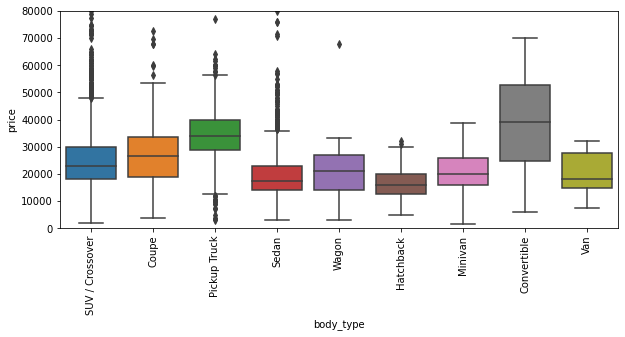

In [62]:
plt.figure(figsize=(10,4))
sns.boxplot(x="body_type",y="price", data = data)
plt.xticks(rotation=90)
plt.ylim(0,80000)

plt.plot()

body_type seems to have a significant trend right away. We cancheck value counts to see if some types are more common than others

In [63]:
data.body_type.value_counts()

SUV / Crossover    3041
Sedan              1655
Pickup Truck        642
Minivan             206
Coupe               146
Wagon               124
Hatchback           110
Convertible          63
Van                  13
Name: body_type, dtype: int64

Have enough observations for each value to be valid, none of the smaller groups stand out substantially, convertible is a little bit spread but that should be fine -> convert to dummies

In [64]:
# change spelling so colummns will be callable
data_2['body_type'] = o_data['body_type'].apply(lambda x: 'SUV_Crossover' if x == 'SUV / Crossover' else 
                                                          'Pickup_Truck' if x == 'Pickup Truck' else
                                                x)
# get dummies
data_2 = pd.get_dummies(data_2, columns=['body_type'], drop_first=True)

[]

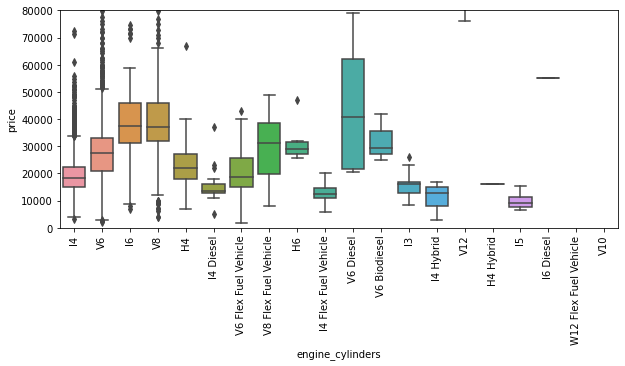

In [65]:
plt.figure(figsize=(10,4))

sns.boxplot(x="engine_cylinders",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

In [66]:
o_data.engine_cylinders.value_counts()

I4                       2985
V6                       1905
V8                        527
V6 Flex Fuel Vehicle      183
H4                        161
V8 Flex Fuel Vehicle       96
I6                         56
I4 Flex Fuel Vehicle       22
I4 Diesel                  17
I3                         13
V6 Diesel                   8
H6                          7
V6 Biodiesel                5
I5                          4
I4 Hybrid                   3
V12                         3
V10                         2
H4 Hybrid                   1
I6 Diesel                   1
W12 Flex Fuel Vehicle       1
Name: engine_cylinders, dtype: int64

Turn anything under 100 observations into 'other', if there is only one observation this is not useful data.

In [67]:
data_2['engine_cylinders'] = o_data['engine_cylinders'].apply(lambda x: 'I4' if x == 'I4' else 
                                                          'V6' if x == 'V6' else
                                                          'V8' if x == 'V8' else
                                                          'V6_Flex_Fuel_Vehicle' if x == 'V6 Flex Fuel Vehicle' else
                                                          'H4' if x == 'H4' else
                                                          'other')
data_2.engine_cylinders.value_counts()

I4                      2985
V6                      1905
V8                       527
other                    239
V6_Flex_Fuel_Vehicle     183
H4                       161
Name: engine_cylinders, dtype: int64

[]

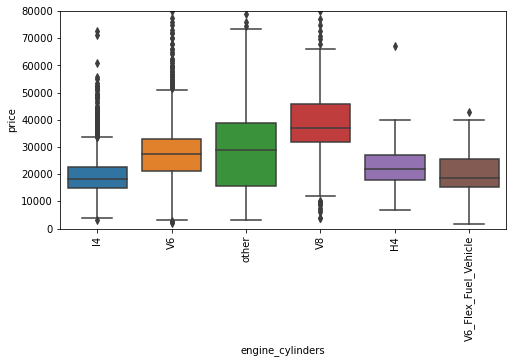

In [68]:
plt.figure(figsize=(8,4))
sns.boxplot(x="engine_cylinders",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Other is naturally with bigger range, but this looks better, get dummies for it:

In [69]:
data_2 = pd.get_dummies(data_2, columns=['engine_cylinders'], drop_first=True)

[]

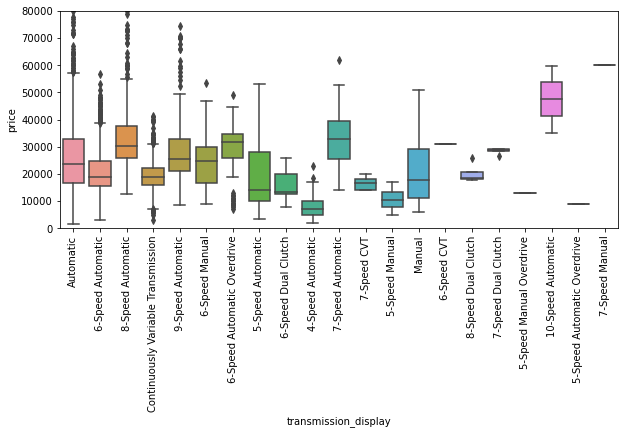

In [70]:
plt.figure(figsize=(10,4))
sns.boxplot(x="transmission_display",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Mean and range seem both to be varying, might be valuable column to predict price, check value counts:

In [71]:
data.transmission_display.value_counts().head()

Automatic                             2277
6-Speed Automatic                     1303
Continuously Variable Transmission     965
8-Speed Automatic                      679
9-Speed Automatic                      284
Name: transmission_display, dtype: int64

[]

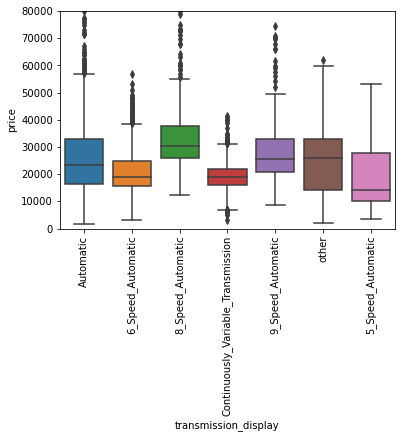

In [72]:
data_2['transmission_display'] = o_data['transmission_display'].apply(lambda x: 'Automatic' if x == 'Automatic' else 
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          'Continuously_Variable_Transmission' if x == 'Continuously Variable Transmission' else
                                                          '8_Speed_Automatic' if x == '8-Speed Automatic' else
                                                          '9_Speed_Automatic' if x == '9-Speed Automatic' else
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          '5_Speed_Automatic' if x == '5-Speed Automatic' else
                                                          'other')
plt.figure(figsize=(6,4))
sns.boxplot(x="transmission_display",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Looks relevant, change in mean and besides 2 relatively small range -> convert into dummies

In [73]:
# turn those columns into dummies
data_2 = pd.get_dummies(data_2, columns=['transmission_display'], drop_first=True)

[]

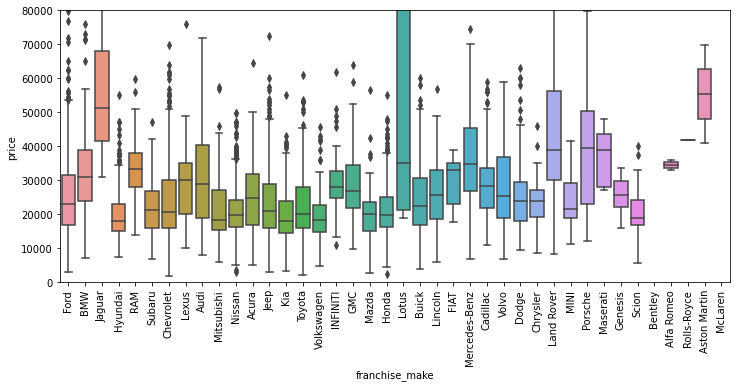

In [74]:
plt.figure(figsize=(12,5))
sns.boxplot(x="franchise_make",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

This seems to be too many columns to just turn into dummies, and as brand is strongly connected to price this seems an important column to keep -> divide brands into groups depending on their mean price, and label encode these groups.

In [75]:
# look at mean price by group
brand_mean_price=data.groupby('franchise_make', as_index=False)['price'].mean()
brand_mean_price=brand_mean_price.sort_values(by=['price'])
brand_mean_price.head()

,franchise_make,price
20,Kia,20001.936275
16,Hyundai,20064.829268
27,Mazda,20135.692857
38,Volkswagen,20160.651007
35,Scion,20897.826087


In [76]:
# sort the brands into groups with similar means
group_0 = brand_mean_price.iloc[0:8,0]
group_1 = brand_mean_price.iloc[8:14,0]
group_2 = brand_mean_price.iloc[14:19,0]
group_3 = brand_mean_price.iloc[19:25,0]
group_4 = brand_mean_price.iloc[25:34,0]
group_5 = brand_mean_price.iloc[34:38,0]
group_6 = brand_mean_price.iloc[38:40,0]

# write function to get names
def get_names (group):
    final = []
    for i in range(0,len(group)):
        name = group.iloc[i]
        final.append(name)
    return(final)
# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['franchise_make'] = o_data['franchise_make'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [77]:
data.listed_date.value_counts().head()

2020-09-02    207
2020-08-28    157
2020-09-03    153
2020-08-26    145
2020-08-27    144
Name: listed_date, dtype: int64

In [78]:
#simply turn into numerical
import datetime
data_2['listed_date']=pd.to_datetime(data_2["listed_date"]).dt.strftime("%Y%m%d")
data_2['listed_date']=data_2.listed_date.astype(int)
# get correlation
data_2['listed_date'].corr(data_2['price'])

-0.12547087176248412

Has a negative correlation between listing date and price, rather small

In [79]:
data.model_name.value_counts().head()

F-150             187
Escape            166
Rogue             146
Silverado 1500    136
Accord            125
Name: model_name, dtype: int64

Looking at both head and tail, there is a good distribution of the different model names, not one that is prelevant wherease the rest only has 1 or 2 entries -> group and turn into numeric

In [80]:
# look at grouped mean
make_mean_price=data.groupby('model_name', as_index=False)['price'].mean()
make_mean_price=make_mean_price.sort_values(by=['price'])
make_mean_price.head()

,model_name,price
240,QX4,2000.0
202,Mariner Hybrid,2953.0
116,Explorer Sport Trac,2995.0
224,Park Avenue,3000.0
124,Five Hundred,3000.0


In [81]:
# like with other column, divide 361 rows into 7 groups, different sizes but around same mean
group_0 = make_mean_price.iloc[0:100,0] # 2000-15000
group_1 = make_mean_price.iloc[100:194,0] # 15000-25000 
group_2 = make_mean_price.iloc[194:237,0] # 25000-30000 
group_3 = make_mean_price.iloc[237:279,0] # 30000-35000
group_4 = make_mean_price.iloc[279:329,0] # 35000-50000
group_5 = make_mean_price.iloc[319:352,0] # 50000-10000
group_6 = make_mean_price.iloc[352:362,0] # rest

# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['model_name'] = o_data['model_name'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [86]:
# drop first letter of each row
data_2['trimId'] = data['trimId'].str.slice(1)
# convert to integer
data_2['trimId']=data_2.trimId.astype(int)
# look at correlation
data_2['trimId'].corr(data_2['price'])

0.29918357172730936

In [93]:
# drop categorical version of columns we have numerical copy of
data_2 = data_2.drop(columns=["transmission","wheel_system_display","fuel_type","wheel_system"], axis = 1)

In [94]:
dat_types = pd.DataFrame(data_2.dtypes)

In [95]:
dat_types.value_counts()

uint8      19
float64    18
int64      15
int32       6
dtype: int64

In [97]:
data_2.shape

(6000, 58)

In [98]:
data = data_2

### Feature Selection 

In [99]:
final_corrs = pd.DataFrame(data.corrwith(data.price)).reset_index().sort_values(by = 0, ascending = False)

final_corr_cols = list(final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]['index'])
final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]

,index,0
21,model_name,0.582557
23,power,0.517518
30,torque,0.513047
4,engine_displacement,0.359656
9,fuel_tank_volume,0.349802
50,engine_cylinders_V8,0.309665
32,wheelbase,0.303458
31,trimId,0.299184
34,year,0.292627
7,franchise_make,0.291321


In [101]:
X = data.copy()

for col in X:
    if col not in final_corr_cols:
        X.drop(col, axis = 1, inplace = True)

X.shape

(6000, 19)

We have 20 predictors which have a reasonable correlation with price which we will be the only predictors we use in our model building. 

When we develop our models, we will print the feature importances and note which features are deemed significant by each model. 

In [111]:
# removing the previously found outlying observation after finalizing data 
y = data_2.price
y.loc[y >= 800000]

951    859000.0
Name: price, dtype: float64

In [112]:
X.drop(951, inplace = True)
y.drop(951, inplace = True)

In [113]:
# checking for any new NAs 
final_dat.isna().sum()

city_fuel_economy       0
engine_displacement     0
franchise_make          0
fuel_tank_volume        1
height                  1
highway_fuel_economy    0
length                  1
mileage                 0
model_name              0
power                   0
savings_amount          0
torque                  0
trimId                  0
wheelbase               1
width                   1
year                    0
wheel_system_cat        0
engine_cylinders_I4     0
engine_cylinders_V8     0
dtype: int64

The original dataset had '--' for this one observation. When we performed the data cleaning and prep, these observations were not considered missing but became missing after our feature engineering. We can drop this observation since it is only one row with data missing from the original source. 

In [114]:
X.isna().sum()
X.iloc[29]
X.drop(29, inplace = True)
y.drop(29, inplace = True)

In [119]:
X.to_csv('X.csv')
y.to_csv('y.csv')

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

# ALWAYS USE RANDOM_STATE = 4

In [115]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

### Lasso, Ridge & Stepwise Selection
*By Emily Leibfritz*

### MARS & Bagging MARS 
*By Hiba Khatib*

#### Base Mars Model

In [116]:
base_mars = Earth().fit(X_train, y_train)
mean_squared_error(y_test, base_mars.predict(X_test), squared = False)

5150.7539906467255

In [117]:
print(base_mars.summary())

Earth Model
--------------------------------------------------
Basis Function               Pruned  Coefficient  
--------------------------------------------------
(Intercept)                  No      64772.8      
h(model_name-5)              No      105007       
h(5-model_name)              No      -4200.46     
h(mileage-26175)             No      -0.0684419   
h(26175-mileage)             No      0.195178     
h(torque-560)                No      -118.635     
h(560-torque)                No      -25.3115     
h(trimId-89792)              No      -1.1421      
h(89792-trimId)              No      -0.185033    
h(savings_amount-2679)       No      3.23426      
h(2679-savings_amount)       Yes     None         
h(engine_displacement-6400)  No      488.495      
h(6400-engine_displacement)  No      1.24199      
wheelbase                    No      -251.999     
h(franchise_make-5)          No      -21251.7     
h(5-franchise_make)          No      -535.296     
wheel_system_cat   

#### Coarse Gridsearch MARS

In [118]:
mars_params = {'max_degree': range(1, 10),
              'enable_pruning': [True, False]}

mars_grid = GridSearchCV(Earth(), mars_params, 
                         scoring = 'neg_mean_absolute_error', n_jobs = -1, cv = 5, verbose = 1)
mars_grid.fit(X_train, y_train)

print("Best MARS params: ", mars_grid.best_params_)
print("Tuned mars model RMSE:", mean_squared_error(y_test, mars_grid.predict(X_test), squared = False))
print(mars_grid.best_estimator_.summary())

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best MARS params:  {'enable_pruning': True, 'max_degree': 4}
Tuned mars model RMSE: 4796.447498691177
Earth Model
--------------------------------------------------------------------------
Basis Function                                      Pruned  Coefficient   
--------------------------------------------------------------------------
(Intercept)                                         No      88555.5       
h(model_name-5)                                     No      37859.6       
h(5-model_name)                                     No      -10191.6      
h(mileage-26175)                                    No      -0.329177     
h(26175-mileage)                                    No      1.19366       
h(model_name-5)*h(mileage-26175)                    No      -4.65058      
h(5-model_name)*h(mileage-26175)                    No      0.00827854    
h(torque-560)                                       No      105.497       


### Decision Trees & Bagging Decision Trees
*By Nicole Birova*

### Random forest 
*By Hiba Khatib*

### AdaBoost & Gradient boosting
*By YuYan Zhang*

### XGBoost
*By Emily Leibfritz*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.